In [ ]:
!mkdir -p energy-capstone/data/raw
!mkdir -p energy-capstone/data/cleaned
!mkdir -p energy-capstone/data/external

In [ ]:
# This first command zips your entire project folder into a single file.
!zip -r -q /content/energy-capstone-project.zip /content/energy-capstone

# This second command copies that new zip file to your main Google Drive directory.
!cp /content/energy-capstone-project.zip /content/drive/MyDrive/

print("✅ Project successfully zipped and copied to your Google Drive!")
print("Look for the file named 'energy-capstone-project.zip' in your 'My Drive' folder.")

✅ Project successfully zipped and copied to your Google Drive!
Look for the file named 'energy-capstone-project.zip' in your 'My Drive' folder.


In [ ]:
!curl -o energy-capstone/data/raw/household_power_consumption.zip \
 https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

!unzip -q energy-capstone/data/raw/household_power_consumption.zip -d energy-capstone/data/raw/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.6M    0 19.6M    0     0  42.5M      0 --:--:-- --:--:-- --:--:-- 42.5M


In [ ]:
import pandas as pd

# Load raw data
raw_path = "energy-capstone/data/raw/household_power_consumption.txt"
df = pd.read_csv(raw_path, sep=';', na_values='?', low_memory=False)

# Combine Date + Time into datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True, errors='coerce')
df = df.drop(columns=['Date','Time']).set_index('datetime').sort_index()

# Convert numeric columns
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Resample to hourly frequency
df_hourly = df.resample('1H').mean()

# Interpolate missing values
df_hourly = df_hourly.interpolate(method='time').ffill().bfill()

# Save cleaned data
df_hourly.to_csv("energy-capstone/data/cleaned/household_power_hourly.csv")

# Quick look
df_hourly.head()


/tmp/ipython-input-2712111007.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [ ]:
import pandas as pd
import numpy as np

print("Loading and cleaning UCI data...")
# Load UCI raw dataset (minute-level)
uci_path = "energy-capstone/data/raw/household_power_consumption.txt"
uci = pd.read_csv(uci_path, sep=';', na_values='?', low_memory=False)

# Parse datetime and set index
uci['datetime'] = pd.to_datetime(uci['Date'] + ' ' + uci['Time'], dayfirst=True, errors='coerce')
uci = uci.drop(columns=['Date','Time']).set_index('datetime').sort_index()

# FIX: Localize the naive UCI datetime index to UTC to match the London data
uci = uci.tz_localize('UTC', ambiguous='infer')

# Convert all numeric columns and add household ID
uci = uci.apply(pd.to_numeric, errors='coerce')
uci['household_id'] = 'UCI_H1'

# ---

print("Loading and cleaning London smart meter data...")
# The London data is split into many files. We'll load the first one as a sample.
london_path = "energy-capstone/data/raw/halfhourly_dataset/halfhourly_dataset/block_0.csv"
london = pd.read_csv(london_path)

# Rename columns, parse datetime as UTC, and set index
london = london.rename(columns={'tstp':'datetime', 'energy(kWh/hh)':'energy_kwh'})
london['household_id'] = london['LCLid']
london['datetime'] = pd.to_datetime(london['datetime'], utc=True)
london = london.set_index('datetime').drop(columns=['LCLid']).sort_index()

# Handle potential string values in energy column
london['energy_kwh'] = pd.to_numeric(london['energy_kwh'], errors='coerce')

# ---

print("Combining both datasets...")
# Convert UCI's 'Global_active_power' (kW) to kWh for each minute
uci['energy_kwh'] = uci['Global_active_power'] * (1/60)

# Select only the common columns we need
common_cols = ['household_id', 'energy_kwh']
uci_df = uci.reset_index()[['datetime'] + common_cols]
london_df = london.reset_index()[['datetime'] + common_cols]

# Concatenate the two dataframes
combined = pd.concat([uci_df, london_df], ignore_index=True)
combined = combined.sort_values(by=['datetime', 'household_id']).reset_index(drop=True)

# Drop rows where energy is missing
combined.dropna(subset=['energy_kwh'], inplace=True)

# ---

print("Saving the combined dataset...")
output_path = "energy-capstone/data/cleaned/combined_energy.parquet"
combined.to_parquet(output_path, index=False)

print(f"\n✅ Success! Combined dataset created with {len(combined):,} rows.")
print(f"File saved to: {output_path}")

combined.head()

Loading and cleaning UCI data...
Loading and cleaning London smart meter data...


FileNotFoundError: [Errno 2] No such file or directory: 'energy-capstone/data/raw/halfhourly_dataset/halfhourly_dataset/block_0.csv'

In [ ]:
import pandas as pd
import requests

# Step 1: Load our combined energy data to find its date range
print("Loading energy data to determine date range...")
energy_df = pd.read_parquet('energy-capstone/data/cleaned/combined_energy.parquet')
energy_df['datetime'] = pd.to_datetime(energy_df['datetime'])

start_date = energy_df['datetime'].min().strftime('%Y-%m-%d')
end_date = energy_df['datetime'].max().strftime('%Y-%m-%d')
print(f"Date range for weather data: {start_date} to {end_date}")

# Step 2: Construct the API URL and fetch weather data for London
print("\nFetching weather data from Open-Meteo API...")
# Coordinates for London, UK
latitude = 51.5074
longitude = -0.1278

# Construct the API URL with our dates
api_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}&"
    f"start_date={start_date}&end_date={end_date}&"
    f"hourly=temperature_2m"
)

response = requests.get(api_url)
weather_data = response.json()
print("Weather data fetched successfully!")

# Step 3: Convert the weather data into a clean pandas DataFrame
print("\nProcessing weather data...")
weather_df = pd.DataFrame(weather_data['hourly'])
weather_df = weather_df.rename(columns={'time': 'datetime', 'temperature_2m': 'temperature_celsius'})

# Convert datetime column to match our energy data's timezone (UTC)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=True)

# Save the cleaned weather data
weather_output_path = "energy-capstone/data/cleaned/weather_hourly_london.parquet"
weather_df.to_parquet(weather_output_path, index=False)

print(f"\n✅ Success! Cleaned weather data saved to: {weather_output_path}")
weather_df.head()

In [ ]:
from google.colab import files
files.download("energy-capstone/data/cleaned/household_power_hourly.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Step 1: Load both of your clean datasets
print("Loading clean energy and weather datasets...")
energy_df = pd.read_parquet('energy-capstone/data/cleaned/combined_energy.parquet')
weather_df = pd.read_parquet('energy-capstone/data/cleaned/weather_hourly_london.parquet')

# Ensure the datetime columns are in the correct format
energy_df['datetime'] = pd.to_datetime(energy_df['datetime'])
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

# Step 2: Perform a time-series merge
print("Merging the two datasets...")
# We sort both DataFrames by time, which is required for this type of merge
energy_df = energy_df.sort_values('datetime')
weather_df = weather_df.sort_values('datetime')

# 'pd.merge_asof' is perfect for this. It matches each energy reading
# with the most recent weather reading before it.
master_df = pd.merge_asof(
    left=energy_df,
    right=weather_df,
    on='datetime',
    direction='backward' # Finds the last weather entry at or before the energy timestamp
)

# Step 3: Check and save the final master dataset
print("\nChecking the merged data...")
master_df.info()

# Drop any rows that might not have a weather match (e.g., very early energy readings)
master_df.dropna(subset=['temperature_celsius'], inplace=True)

output_path = 'energy-capstone/data/cleaned/master_dataset.parquet'
master_df.to_parquet(output_path, index=False)

print(f"\n✅ Phase 1 Complete! Master dataset saved to: {output_path}")
master_df.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive

# Mount Google Drive (will require authorization)
drive.mount('/content/drive')

# Zip the entire project folder
print("\nZipping project folder...")
!zip -r -q /content/energy-capstone-project.zip /content/energy-capstone

# Copy the zip file to your Google Drive
print("Copying to Google Drive...")
!cp /content/energy-capstone-project.zip /content/drive/MyDrive/

print("\n✅ All done! Project saved as 'energy-capstone-project.zip' in your Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Zipping project folder...
Copying to Google Drive...

✅ All done! Project saved as 'energy-capstone-project.zip' in your Google Drive.


Loading model-ready file: merged_power_and_weather.csv...
Successfully loaded 'merged_power_and_weather.csv'.
Original shape: (26582, 21)
Shape after dropping NaNs: (26558, 21)

--- Splitting the Data ---
Data split successfully:
Training data has 21246 rows
Testing data has 5312 rows


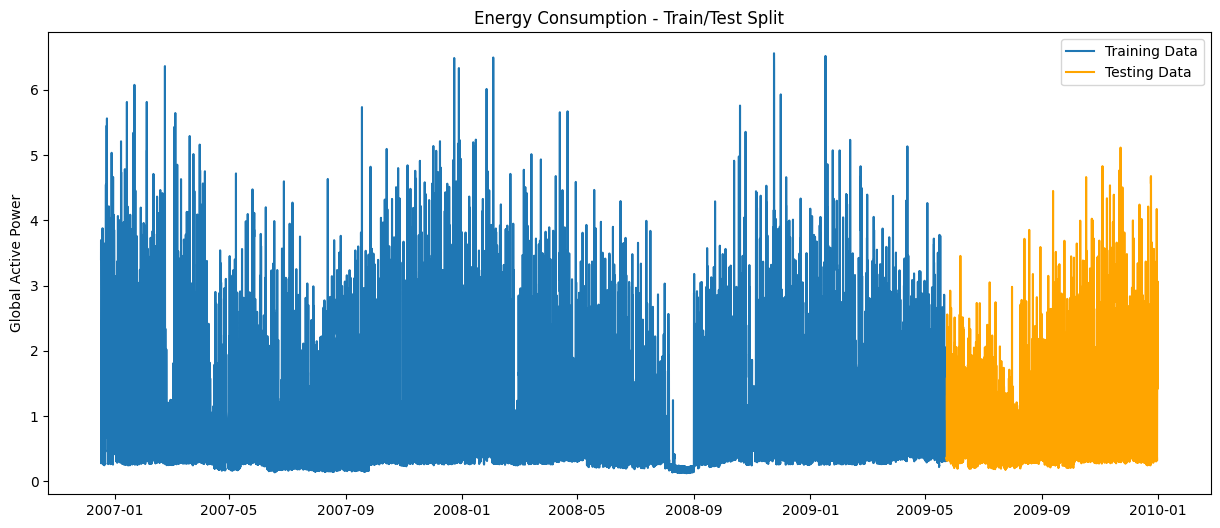

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1.1: Load the Model-Ready File ===
# This file is ALREADY processed and has features.
file_name = 'merged_power_and_weather.csv'
print(f"Loading model-ready file: {file_name}...")

try:
    df = pd.read_csv(
        file_name,
        parse_dates=['DateTime'], # Use the correct column name 'DateTime'
        index_col='DateTime'      # Set it as the index
    )
    print(f"Successfully loaded '{file_name}'.")

except FileNotFoundError:
    print(f"ERROR: File '{file_name}' not found.")
    print("Please make sure you have uploaded it to your Colab session.")
    raise

# === Step 1.2: Handle Missing Values from Lag/Rolling Features ===
# The lag/rolling features in the file (like 'lag_power_24h')
# create 'NaN' values for the first 24 rows. We must drop them.
print(f"Original shape: {df.shape}")
df = df.dropna()
print(f"Shape after dropping NaNs: {df.shape}")

# === Step 1.3: Split the Data ===
print("\n--- Splitting the Data ---")

split_percentage = 0.8
split_point = int(len(df) * split_percentage)

train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

print(f"Data split successfully:")
print(f"Training data has {len(train_data)} rows")
print(f"Testing data has {len(test_data)} rows")

# === Step 1.4: Visualize the Split ===
plt.figure(figsize=(15, 6))
plt.plot(train_data['Global_active_power'], label='Training Data')
plt.plot(test_data['Global_active_power'], label='Testing Data', color='orange')
plt.title('Energy Consumption - Train/Test Split')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
import warnings

# --- Step 2.1: Define the Model Parameters ---

# SARIMA requires a set of parameters: (p,d,q) and (P,D,Q,m)

# (p,d,q) = Non-seasonal parameters
# (P,D,Q,m) = Seasonal parameters
# m = The number of time steps in a single seasonal period.
# Since our data is hourly and has a strong DAILY pattern, m = 24.

# We'll start with some common, simple parameters.
# (Finding the *perfect* parameters is a later step called "tuning")
my_order = (1, 1, 1)        # (p,d,q)
my_seasonal_order = (1, 1, 1, 24) # (P,D,Q,m)

print("Starting to build the SARIMA model...")
print(f"Order: {my_order}, Seasonal Order: {my_seasonal_order}")

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

# --- Step 2.2: Create and "Fit" (Train) the Model ---

# We are training the model to predict the 'Global_active_power'
# using our 'train_data'
sarima_model = sm.tsa.SARIMAX(
    train_data['Global_active_power'], # The data to learn from
    order=my_order,
    seasonal_order=my_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

# This is the part that does the actual "learning".
# It can take a few minutes, so be patient!
print("Training the model... This may take a few minutes...")
sarima_results = sarima_model.fit()

print("\n✅ Model training complete!")

# --- Step 2.3: View the Model Summary ---

# This output tells you all about the model it just learned.
print(sarima_results.summary())

Starting to build the SARIMA model...
Order: (1, 1, 1), Seasonal Order: (1, 1, 1, 24)
Training the model... This may take a few minutes...

✅ Model training complete!
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                21246
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -19866.830
Date:                            Wed, 12 Nov 2025   AIC                          39743.660
Time:                                    16:52:01   BIC                          39783.467
Sample:                                         0   HQIC                         39756.647
                                          - 21246                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

In [ ]:
# --- Step 3.1: Define the Prediction Range ---

# We want our model to predict a number of steps
# equal to the entire length of our test set.
num_steps = len(test_data)

print(f"Our model (trained on train_data) will now predict {num_steps} steps into the future.")

# --- Step 3.2: Get the Forecast ---

# Use the .get_forecast() method from the results
# This generates the predicted values
sarima_forecast = sarima_results.get_forecast(steps=num_steps)

# --- Step 3.3: Get the Predicted Values ---

# The forecast object is complex, but we just want the main prediction,
# which is stored in 'predicted_mean'
predicted_values = sarima_forecast.predicted_mean

print("✅ Forecast complete!")

# --- Step 3.4: Look at the Predictions ---

# Let's look at the first few predicted values
print("\nFirst 5 predicted values:")
print(predicted_values.head())

Our model (trained on train_data) will now predict 5312 steps into the future.
✅ Forecast complete!

First 5 predicted values:
21246    0.352510
21247    0.330702
21248    0.372309
21249    0.879510
21250    1.437960
Name: predicted_mean, dtype: float64


--- Model Evaluation ---
Mean Squared Error (MSE): 1.0117
Root Mean Squared Error (RMSE): 1.0058

Generating forecast plot...


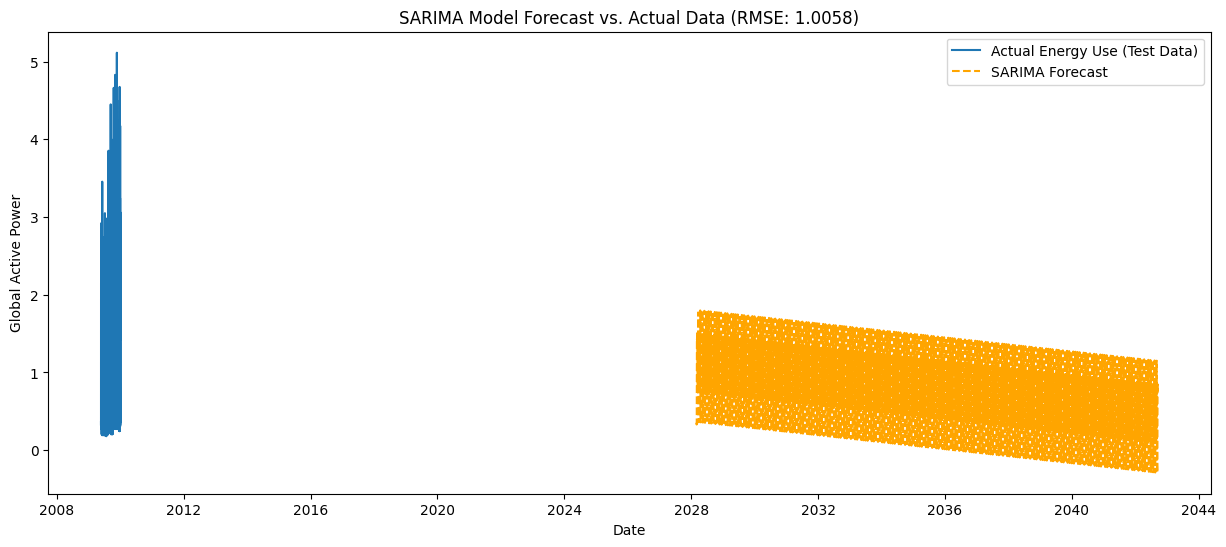

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Step 4.1: Calculate Evaluation Metrics ---

# We compare the "actual" values from our test set...
actual_values = test_data['Global_active_power']

# ...to the "predicted" values from our model.
# predicted_values was created in Step 3

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# Calculate the Root Mean Squared Error (RMSE)
# This is a common metric for forecasting, and it's in the same
# units as your original data (Global_active_power).
rmse = np.sqrt(mse)

print(f"--- Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# --- Step 4.2: Visualize the Forecast ---

print("\nGenerating forecast plot...")

# Create a figure to hold the plot
plt.figure(figsize=(15, 6))

# Plot the "actual" data from the test set
plt.plot(actual_values, label='Actual Energy Use (Test Data)')

# Plot the "predicted" data from our model
plt.plot(predicted_values, label='SARIMA Forecast', color='orange', linestyle='--')

# Add labels and a title
plt.title(f'SARIMA Model Forecast vs. Actual Data (RMSE: {rmse:.4f})')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# --- Step 5.1: Select and Scale the Data ---

# LSTMs work best with scaled data (all values between 0 and 1).
# We'll use the 'MinMaxScaler' for this.
scaler = MinMaxScaler()

# We only want to scale the 'Global_active_power' column for this model.
# Note: We fit the scaler ONLY on the training data to prevent
# information from the test set "leaking" into our training process.
scaled_train_data = scaler.fit_transform(train_data[['Global_active_power']])
scaled_test_data = scaler.transform(test_data[['Global_active_power']])

print("Data scaling complete.")

# --- Step 5.2: Define the Sequence "Window" ---

# This is the most important part for an LSTM.
# We will tell the model to look at a "window" of the last 24 hours
# to predict the 1 hour immediately after.
n_input = 24  # Look at the last 24 hours...
n_features = 1 # ...of our 1 feature (Global_active_power)
batch_size = 32 # Process data in batches of 32

# --- Step 5.3: Create the Sequence Generators ---

# These "generators" will feed the data to the LSTM in the
# "window" format (24 hours in, 1 hour out) that it needs.

# Training data generator
train_generator = TimeseriesGenerator(
    scaled_train_data,      # The data to use
    scaled_train_data,      # The target (it's the same data)
    length=n_input,         # How many hours to look back (24)
    batch_size=batch_size
)

# Testing data generator
test_generator = TimeseriesGenerator(
    scaled_test_data,
    scaled_test_data,
    length=n_input,
    batch_size=batch_size
)

print(f"Timeseries generators created.")
print(f"The model will look at the last {n_input} hours to predict the next hour.")
print(f"Number of training batches: {len(train_generator)}")
print(f"Number of testing batches: {len(test_generator)}")

Data scaling complete.
Timeseries generators created.
The model will look at the last 24 hours to predict the next hour.
Number of training batches: 664
Number of testing batches: 166


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# --- Step 6.1: Define the Model Architecture ---

# We'll use a simple but powerful model:
# 1. An LSTM layer to learn the time-series patterns.
# 2. A Dense (standard) layer to output the final prediction.

model = Sequential()
model.add(LSTM(
    units=50,                # 50 "neurons" or "memory units"
    activation='relu',       # A standard activation function
    input_shape=(n_input, n_features) # (24 hours, 1 feature)
))
model.add(Dense(units=1)) # A single output neuron to predict the next hour

# --- Step 6.2: Compile the Model ---

# "Compiling" means telling the model how to learn.
# - optimizer='adam': A popular and effective learning algorithm.
# - loss='mean_squared_error': We're telling it to minimize the
#   same error (MSE) that we'll use to evaluate it.
model.compile(optimizer='adam', loss='mean_squared_error')

print("LSTM Model defined and compiled successfully.")
print(model.summary()) # Prints a summary of the model layers

# --- Step 6.3: Train the Model ("Fit") ---

print("\nTraining the LSTM model...")
# This is where the learning happens.
# 'epochs=20' means it will "see" the entire dataset 20 times
# to improve its predictions.
# This step will take several minutes to run!
# You will see the training progress for each epoch.
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    verbose=1 # Show the progress bar
)

print("\n✅ LSTM Model training complete!")

LSTM Model defined and compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None

Training the LSTM model...
Epoch 1/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0188 - val_loss: 0.0078
Epoch 2/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 3/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 4/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0097 - val_loss: 0.0071
Epoch 5/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 6/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0100 - val_loss: 0.0071
Epoch 7/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0096 - val_loss: 0.0069
Epoch 8/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0095 - val_loss: 0.0068
Epoch 9/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0094 - val_loss: 0.0068
Epoch 10/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 11/20
664/664 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0093 - val_loss: 0.0066
Epoch 

Making predictions on the test data...
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Predictions un-scaled back to original units.

--- LSTM Model Evaluation ---
Mean Squared Error (MSE): 0.2706
Root Mean Squared Error (RMSE): 0.5202

Generating LSTM forecast plot...


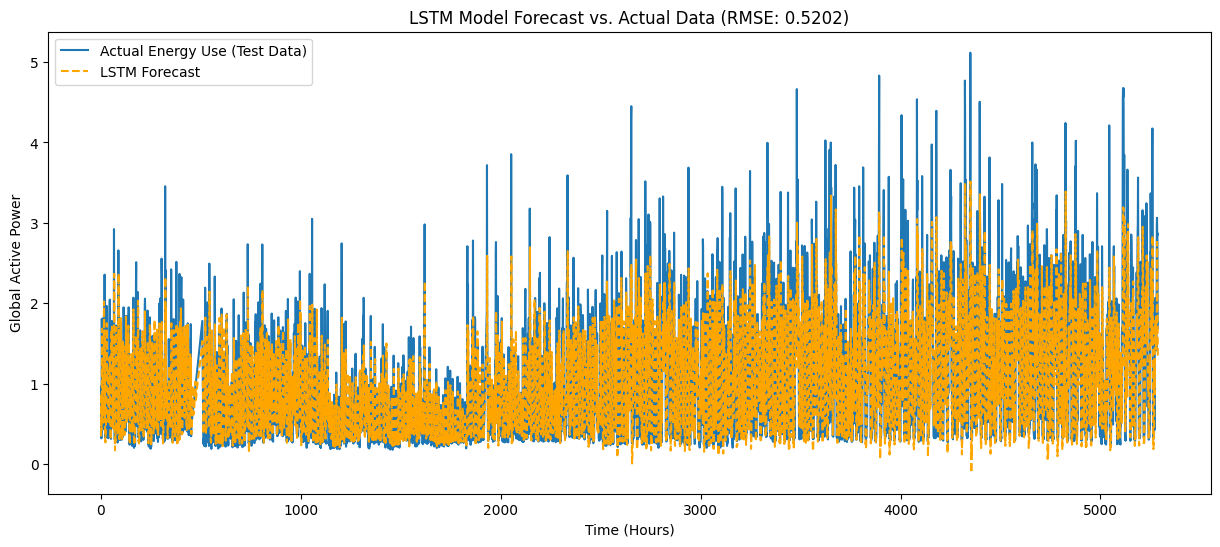

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# --- Step 7.1: Make Predictions on the Test Data ---

# We'll "walk" through our test_generator (which holds the test data)
# and get a prediction for each batch.
print("Making predictions on the test data...")
lstm_predictions_scaled = model.predict(test_generator)

# --- Step 7.2: "Inverse Transform" (Un-scale) the Predictions ---

# The model predicted values between 0 and 1. We need to convert
# them back to their original 'Global_active_power' units
# using the 'scaler' we created in Step 5.
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

print("Predictions un-scaled back to original units.")

# --- Step 7.3: Get the Actual (Un-scaled) Values ---

# The test_generator is 'n_input' (24) steps shorter than the
# original test set, because it needs 24 hours of history
# for its first prediction. We must select the *actual* values
# that correspond to our predictions.
actual_values_lstm = scaler.inverse_transform(scaled_test_data[n_input:])

# --- Step 7.4: Calculate LSTM's RMSE ---

# Now we can compare the real values to our model's predictions
lstm_mse = mean_squared_error(actual_values_lstm, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)

print(f"\n--- LSTM Model Evaluation ---")
print(f"Mean Squared Error (MSE): {lstm_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.4f}")

# --- Step 7.5: Visualize the LSTM Forecast ---

print("\nGenerating LSTM forecast plot...")

# Create a figure to hold the plot
plt.figure(figsize=(15, 6))

# Plot the "actual" data
plt.plot(actual_values_lstm, label='Actual Energy Use (Test Data)')

# Plot the "predicted" data from our LSTM model
plt.plot(lstm_predictions, label='LSTM Forecast', color='orange', linestyle='--')

# Add labels and a title
plt.title(f'LSTM Model Forecast vs. Actual Data (RMSE: {lstm_rmse:.4f})')
plt.xlabel('Time (Hours)')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()